Here, we create a multiclass classifier for classifying the various closest vectors returned by the model, as the corresponding attributes.

In [1]:
import warnings
warnings.filterwarnings('ignore')

from gensim.models.wrappers import FastText
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import pandas as pd
import numpy as np
import h5py
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing import sequence
from keras import models
from keras import layers
from keras import activations
from keras import optimizers
from keras import losses
from keras import metrics
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import keras.preprocessing.text
from keras.models import load_model
from keras.utils import np_utils

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Prepare Dataset

In [2]:
df = pd.read_csv('truth_values_1100_tuples.csv', encoding='utf8', dtype=object)

In [3]:
df.head()

,ProviderNumber,HospitalName,Address1,City,ZipCode,CountyName,PhoneNumber,HospitalOwner,Condition,Sample
0,10018,CALLAHAN EYE FOUNDATION HOSPITAL,1720 UNIVERSITY BLVD,BIRMINGHAM,35233,JEFFERSON,2053258100,Voluntary non-profit - Private,Surgical Infection Prevention,0 patients
1,10018,CALLAHAN EYE FOUNDATION HOSPITAL,1720 UNIVERSITY BLVD,BIRMINGHAM,35233,JEFFERSON,2053258100,Voluntary non-profit - Private,Surgical Infection Prevention,0 patients
2,10018,CALLAHAN EYE FOUNDATION HOSPITAL,1720 UNIVERSITY BLVD,BIRMINGHAM,35233,JEFFERSON,2053258100,Voluntary non-profit - Private,Surgical Infection Prevention,0 patients
3,10018,CALLAHAN EYE FOUNDATION HOSPITAL,1720 UNIVERSITY BLVD,BIRMINGHAM,35233,JEFFERSON,2053258100,Voluntary non-profit - Private,Surgical Infection Prevention,0 patients
4,10018,CALLAHAN EYE FOUNDATION HOSPITAL,1720 UNIVERSITY BLVD,BIRMINGHAM,35233,JEFFERSON,2053258100,Voluntary non-profit - Private,Surgical Infection Prevention,0 patients


In [4]:
len(df)

1100

In [5]:
df.columns.values

array(['ProviderNumber', 'HospitalName', 'Address1', 'City', 'ZipCode',
       'CountyName', 'PhoneNumber', 'HospitalOwner', 'Condition',
       'Sample'], dtype=object)

## Data Cleaning

In [6]:
df['ProviderNumber'] = df['ProviderNumber'].apply(lambda x: str(int(float(x))))
df['ZipCode'] = df['ZipCode'].apply(lambda x: str(int(float(x))))
df['PhoneNumber'] = df['PhoneNumber'].apply(lambda x: str(int(float(x))))

In [7]:
df.head(2)

,ProviderNumber,HospitalName,Address1,City,ZipCode,CountyName,PhoneNumber,HospitalOwner,Condition,Sample
0,10018,CALLAHAN EYE FOUNDATION HOSPITAL,1720 UNIVERSITY BLVD,BIRMINGHAM,35233,JEFFERSON,2053258100,Voluntary non-profit - Private,Surgical Infection Prevention,0 patients
1,10018,CALLAHAN EYE FOUNDATION HOSPITAL,1720 UNIVERSITY BLVD,BIRMINGHAM,35233,JEFFERSON,2053258100,Voluntary non-profit - Private,Surgical Infection Prevention,0 patients


In [8]:
ProviderNumber = df['ProviderNumber'].tolist()
HospitalName = df['HospitalName'].tolist()
Address1 = df['Address1'].tolist()
City = df['City'].tolist()
ZipCode = df['ZipCode'].tolist()
CountyName = df['CountyName'].tolist()
PhoneNumber = df['PhoneNumber'].tolist()
HospitalOwner = df['HospitalOwner'].tolist()
Condition = df['Condition'].tolist()
Sample = df['Sample'].tolist()

In [9]:
values = [ProviderNumber, HospitalName, Address1, City, ZipCode, CountyName, PhoneNumber, HospitalOwner, Condition, Sample]
attributes = ['ProviderNumber', 'HospitalName', 'Address1', 'City','ZipCode','CountyName','PhoneNumber', 'HospitalOwner', 'Condition', 'Sample']

Create value, attribute-name tuple pairs

In [10]:
data = []
for i in range(len(values)):
    for value in values[i]:
        data.append([value, attributes[i]])

In [11]:
len(data)

11000

In [12]:
data[:10]

[['10018', 'ProviderNumber'],
 ['10018', 'ProviderNumber'],
 ['10018', 'ProviderNumber'],
 ['10018', 'ProviderNumber'],
 ['10018', 'ProviderNumber'],
 ['10018', 'ProviderNumber'],
 ['10018', 'ProviderNumber'],
 ['10018', 'ProviderNumber'],
 ['10019', 'ProviderNumber'],
 ['10019', 'ProviderNumber']]

In [13]:
data[-10:]

[['130 patients', 'Sample'],
 ['619 patients', 'Sample'],
 ['242 patients', 'Sample'],
 ['242 patients', 'Sample'],
 ['5 patients', 'Sample'],
 ['2 patients', 'Sample'],
 ['0 patients', 'Sample'],
 ['0 patients', 'Sample'],
 ['2 patients', 'Sample'],
 ['0 patients', 'Sample']]

In [14]:
dfData = pd.DataFrame(data, columns=['Value','Label'])

In [15]:
dfData.head(2)

,Value,Label
0,10018,ProviderNumber
1,10018,ProviderNumber


In [16]:
dfData.tail()

,Value,Label
10995,2 patients,Sample
10996,0 patients,Sample
10997,0 patients,Sample
10998,2 patients,Sample
10999,0 patients,Sample


Convert labels to categorical attributes

In [17]:
dfData['Label'] = dfData['Label'].astype('category')

In [18]:
dfData["Label_Cat"] = dfData["Label"].cat.codes

In [19]:
dfData.tail()

,Value,Label,Label_Cat
10995,2 patients,Sample,8
10996,0 patients,Sample,8
10997,0 patients,Sample,8
10998,2 patients,Sample,8
10999,0 patients,Sample,8


In [20]:
dfData['Label_Cat'].value_counts()

7    1100
6    1100
5    1100
4    1100
3    1100
2    1100
9    1100
1    1100
8    1100
0    1100
Name: Label_Cat, dtype: int64

Get the mapping

In [21]:
mapping = dict(enumerate(dfData['Label'].cat.categories))

In [22]:
mapping

{0: 'Address1',
 1: 'City',
 2: 'Condition',
 3: 'CountyName',
 4: 'HospitalName',
 5: 'HospitalOwner',
 6: 'PhoneNumber',
 7: 'ProviderNumber',
 8: 'Sample',
 9: 'ZipCode'}

Drop the Label column

In [23]:
dfData.drop(['Label'], axis=1, inplace=True)

In [24]:
dfData.head()

,Value,Label_Cat
0,10018,7
1,10018,7
2,10018,7
3,10018,7
4,10018,7


Shuffle the data

In [25]:
dfData = dfData.sample(frac=1).reset_index(drop=True)

In [26]:
dfData.head(10)

,Value,Label_Cat
0,Heart Failure,2
1,2000 PEPPERELL PARKWAY,0
2,20017,7
3,Proprietary,5
4,2567688400,6
5,Surgical Infection Prevention,2
6,MARION REGIONAL MEDICAL CENTER,4
7,10001,7
8,1000 FIRST STREET NORTH,0
9,10086,7


Find the longest string in the value column

In [27]:
dfData.Value.map(lambda x: len(str(x))).max()

43

In [28]:
X = dfData['Value'].tolist()
y = dfData['Label_Cat'].tolist()

## Tokenize and obtain the train, test split

In [31]:
batchSize = 32
maxSequenceLength = 45
maxWords = 1000

In [32]:
tokenizer = Tokenizer(num_words=maxWords)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 667 unique tokens.


In [33]:
data = pad_sequences(sequences, maxlen=maxSequenceLength)

In [34]:
labels = np.asarray(y)

In [35]:
data.shape

(11000, 45)

In [36]:
labels.shape

(11000,)

In [37]:
labels = to_categorical(labels)

In [38]:
labels.shape

(11000, 10)

Shuffle the dataset

In [39]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

In [40]:
data = data[indices]
labels = labels[indices]

## Train test split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=22, stratify=labels)

In [42]:
len(X_train), len(y_train)

(8800, 8800)

In [43]:
len(X_test), len(y_test)

(2200, 2200)

## Model

In [49]:
embeddingDim = 100

**Architecture**
* 1 embedding layer 
* 1 dense layer, 32 hidden units and _relu_ activation
* 1 dense layer, 64 hidden units and _relu_ activation
* Output layer, _softmax_ activation

In [50]:
model = models.Sequential()
model.add(layers.Embedding(maxWords, embeddingDim, input_length=maxSequenceLength))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation=activations.relu))
model.add(layers.Dense(64, activation=activations.relu))
model.add(layers.Dense(10, activation=activations.softmax))

model.compile(optimizer=optimizers.Adam(), loss=losses.categorical_crossentropy, metrics=['accuracy'])

In [51]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 45, 100)           100000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 4500)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                144032    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                650       
Total params: 246,794
Trainable params: 246,794
Non-trainable params: 0
_________________________________________________________________


In [52]:
history = model.fit(X_train, y_train,
                    epochs=3,
                    batch_size=32, 
                    validation_split=0.2)

Train on 7040 samples, validate on 1760 samples
Epoch 1/3
7040/7040 [==============================] - 2s 313us/step - loss: 1.2678 - acc: 0.5862 - val_loss: 0.3644 - val_acc: 0.9818
Epoch 2/3
7040/7040 [==============================] - 2s 240us/step - loss: 0.1220 - acc: 0.9766 - val_loss: 0.0508 - val_acc: 0.9841
Epoch 3/3
7040/7040 [==============================] - 2s 267us/step - loss: 0.0331 - acc: 0.9861 - val_loss: 0.0214 - val_acc: 0.9881


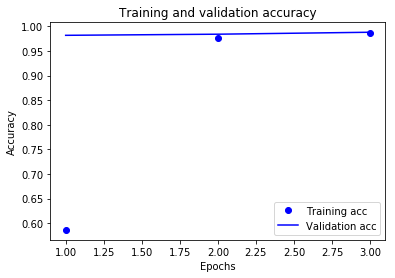

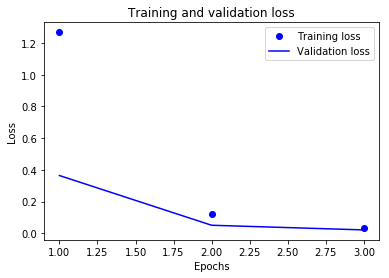

In [53]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();

In [54]:
results = model.evaluate(X_test, y_test)

2200/2200 [==============================] - 0s 103us/step


In [55]:
loss = results[0]
accuracy = results[1]

In [56]:
loss

0.027761752077124335

In [57]:
accuracy

0.9872727270559831

Save the model

In [58]:
model.save("HospitalMultiAttributeClassifier.h5")

Save the tokenizer

In [59]:
with open('HospitalMultiAttributeClassifierTokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL, fix_imports=True)

## Make predictions on new data

In [60]:
model = load_model('HospitalMultiAttributeClassifier.h5')

In [61]:
with open('HospitalMultiAttributeClassifierTokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [86]:
testString = ['YUKON KUSKOKWIM DELTA REG HOSPITAL']

In [87]:
sequences = tokenizer.texts_to_sequences(testString)
testData = pad_sequences(sequences, maxlen=45)

In [88]:
predictions = model.predict(testData)

In [89]:
mapping[np.argmax(predictions[0])]

'HospitalName'